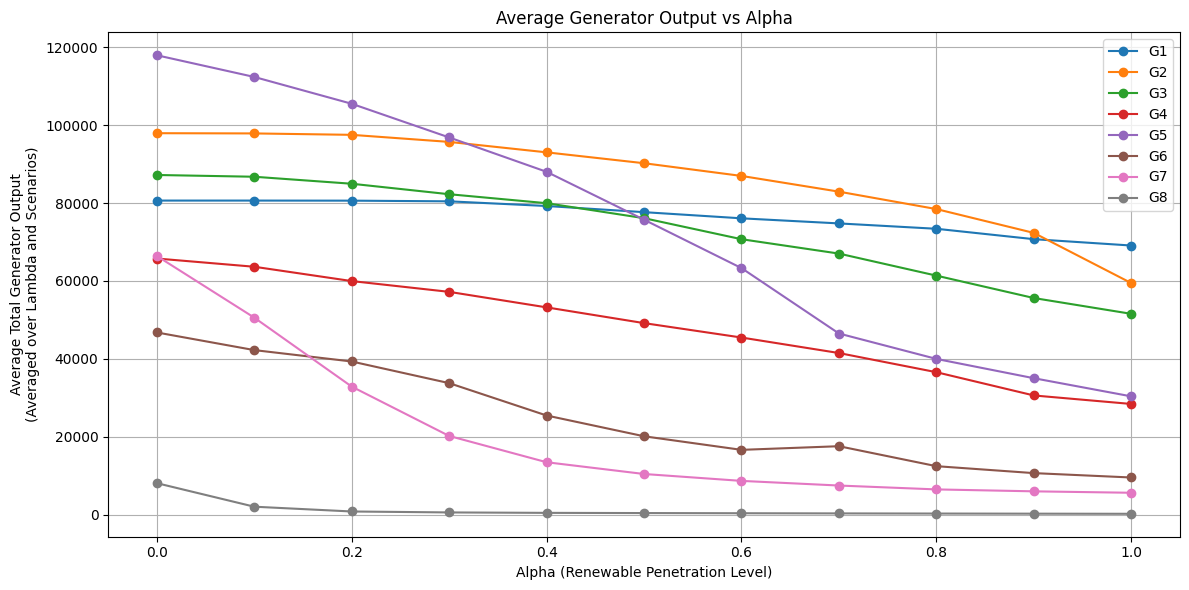

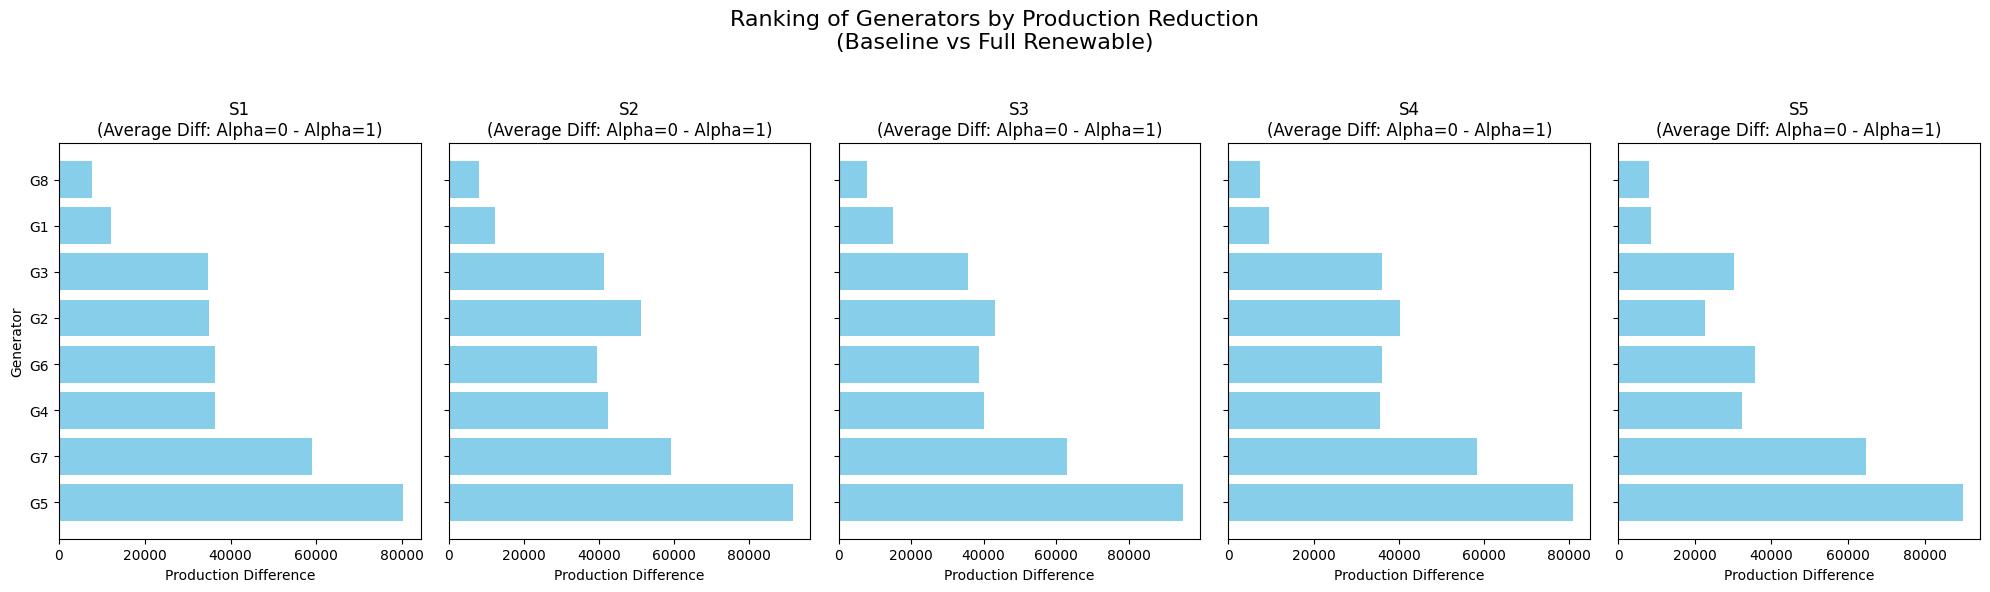

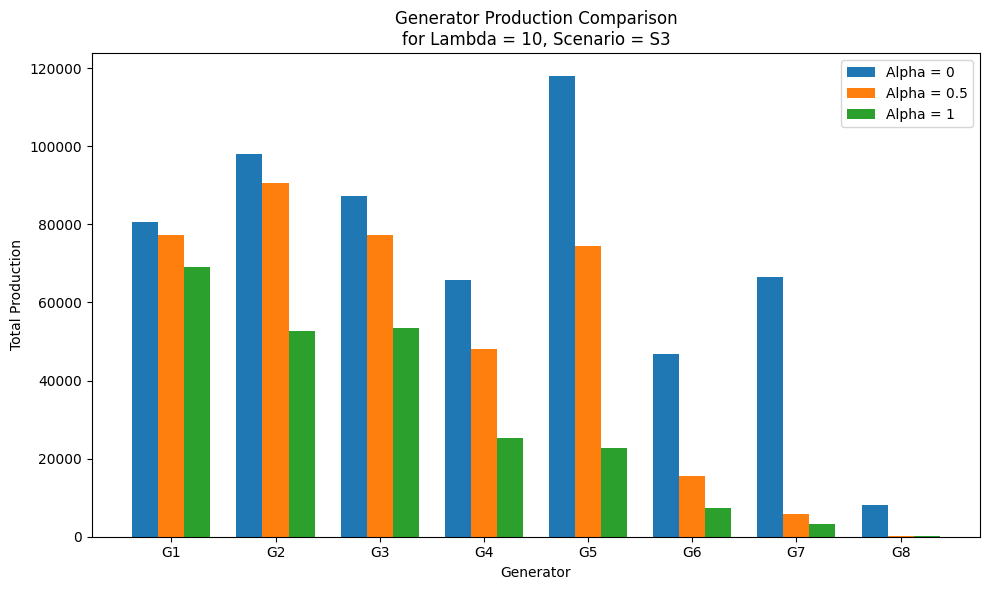

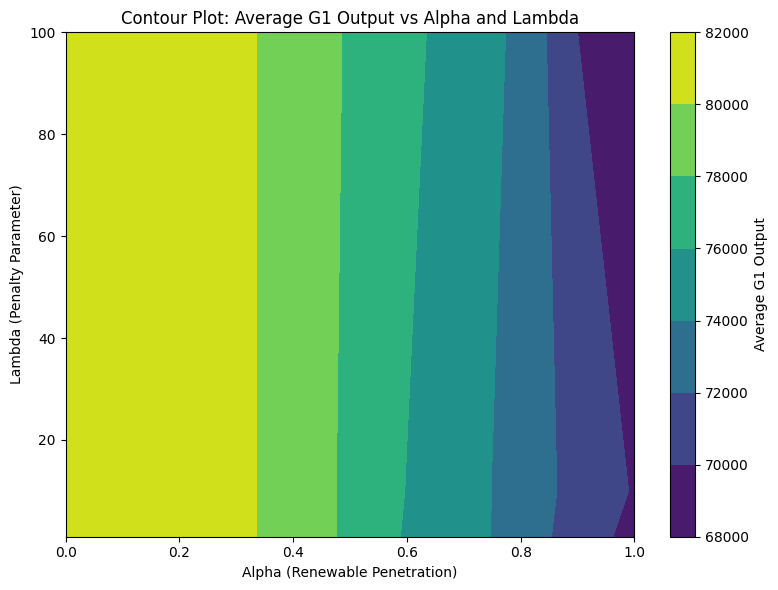

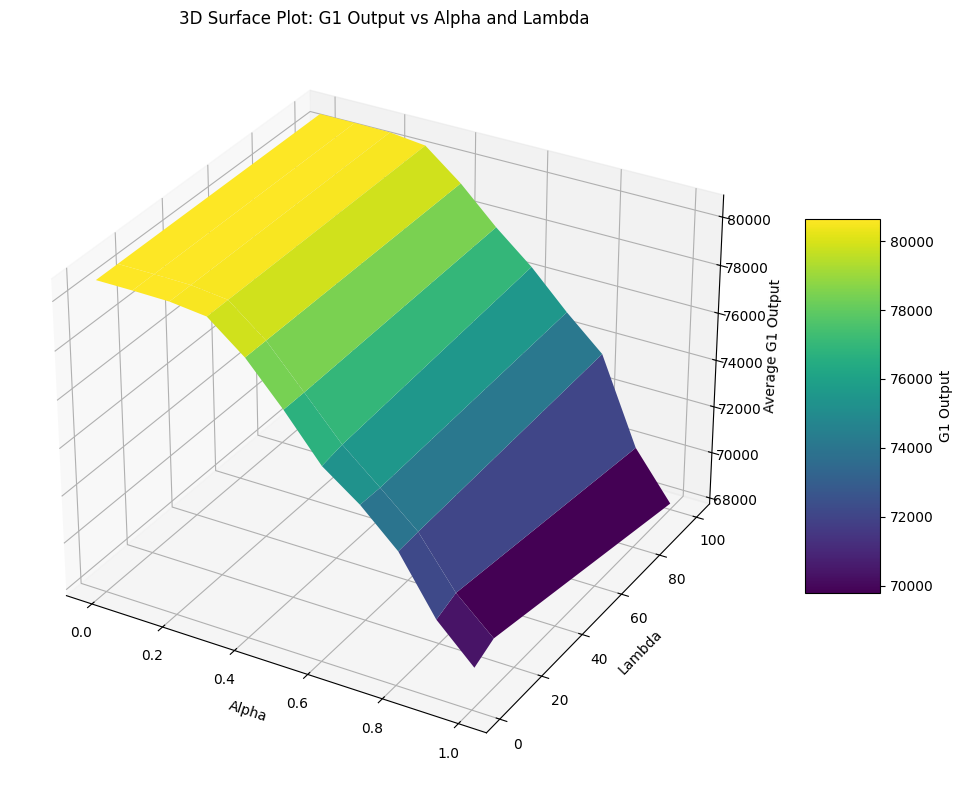

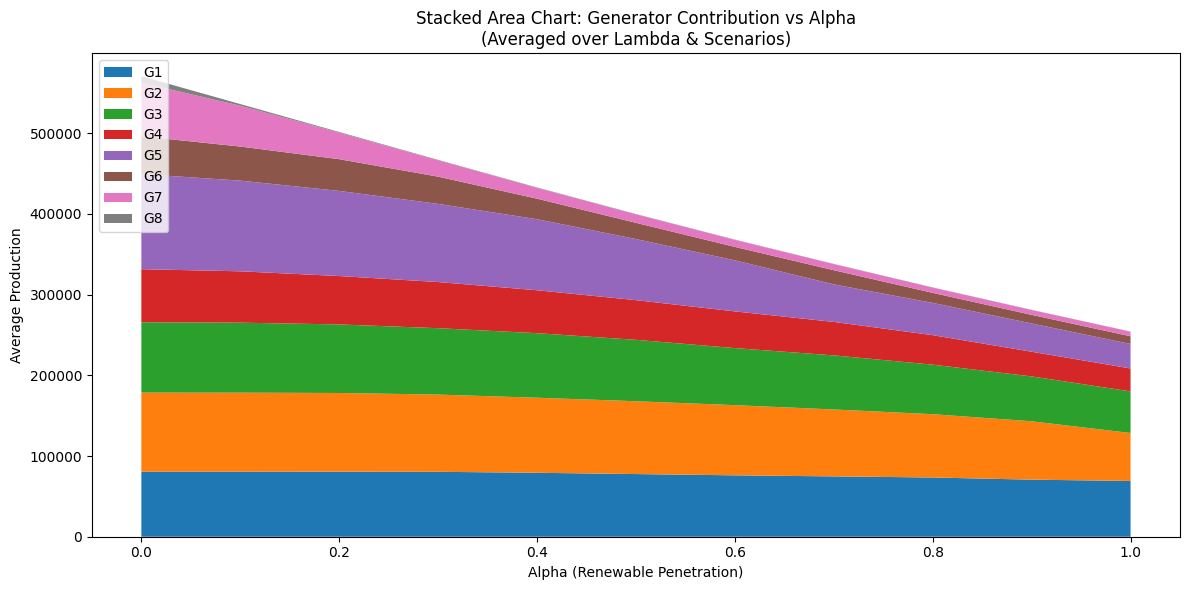

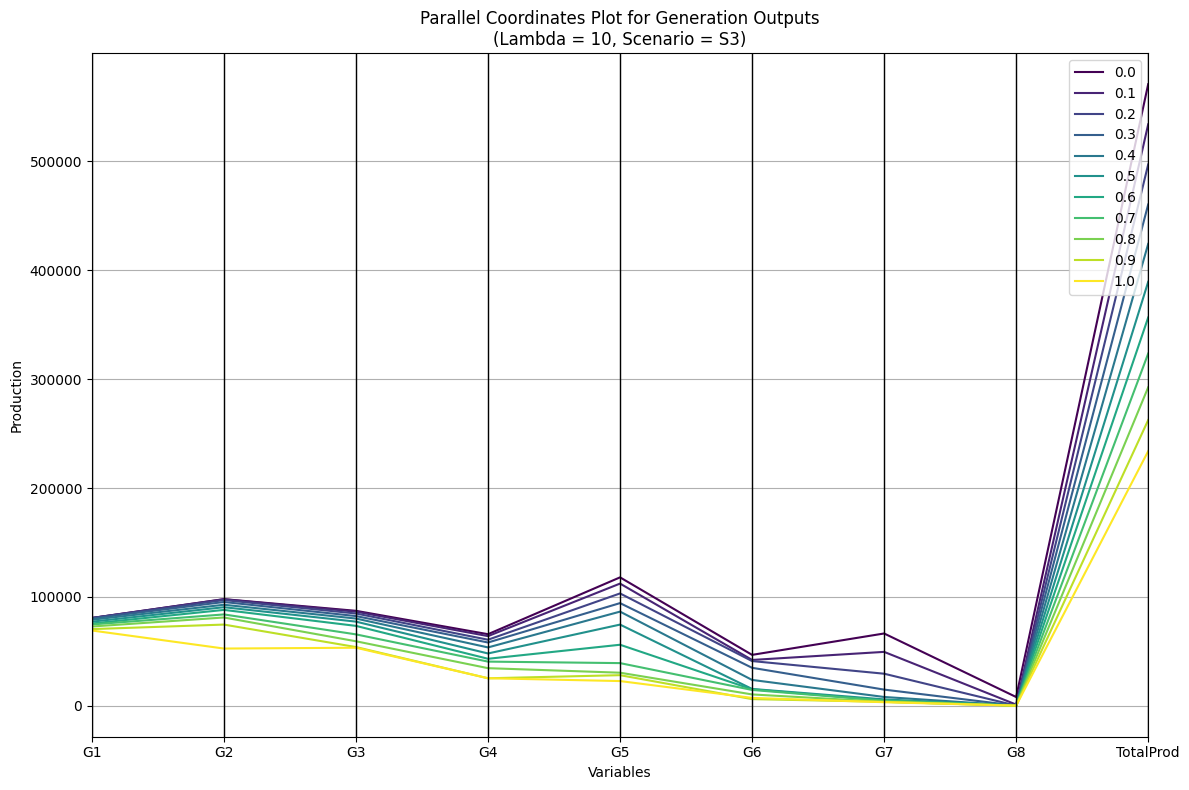

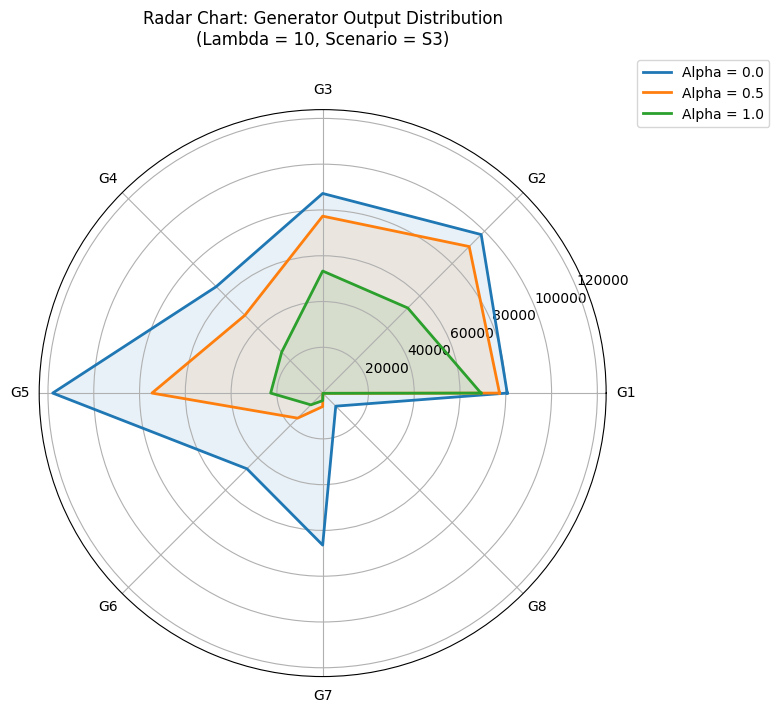

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # For 3D plotting
from pandas.plotting import parallel_coordinates

# =============================================================================
# Section 0: Read Data and Preprocess
# =============================================================================
# Read the Excel file "sensitivity_results.xlsx"
# It is assumed that the Excel file contains the following columns:
# 'Alpha', 'Lambda', 'Scenario', 'G1', 'G2', ..., 'G8'
df = pd.read_excel("sensitivity_results.xlsx")

# Simplify Scenario names by replacing "Renewable Scenario " with "S"
df["Scenario"] = df["Scenario"].str.replace("Renewable Scenario ", "S")

# Define a list of generator names
gen_list = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8']

# =============================================================================
# Section 1: Chart A - Average Generator Output vs Alpha
# =============================================================================
# For all values of Lambda and Scenario, group the data by Alpha and calculate the mean output for each generator.
grouped_avg = df.groupby("Alpha")[gen_list].mean()

# Plot line charts for each generator's average output vs Alpha.
plt.figure(figsize=(12, 6))
for g in gen_list:
    plt.plot(grouped_avg.index, grouped_avg[g], marker='o', label=g)
plt.xlabel("Alpha (Renewable Penetration Level)")
plt.ylabel("Average Total Generator Output\n(Averaged over Lambda and Scenarios)")
plt.title("Average Generator Output vs Alpha")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================================================================
# Section 2: Chart B - Ranking of Generators by Production Reduction
# Compare the production difference between baseline (Alpha = 0) and full renewable (Alpha = 1)
# for each Scenario. For each scenario and Lambda, compute the difference, then average over Lambda.
# =============================================================================
scenarios = sorted(df['Scenario'].unique())
diff_list = []
for scen in scenarios:
    for lam in sorted(df['Lambda'].unique()):
        # Filter data for the current scenario and lambda value
        df_subset = df[(df['Scenario'] == scen) & (df['Lambda'] == lam)]
        # Select rows where Alpha=0 (baseline) and Alpha=1 (full renewable)
        baseline = df_subset[df_subset['Alpha'] == 0]
        full = df_subset[df_subset['Alpha'] == 1]
        if not baseline.empty and not full.empty:
            # Calculate the difference for each generator (baseline - full)
            diff = {g: baseline[g].values[0] - full[g].values[0] for g in gen_list}
            diff['Scenario'] = scen
            diff['Lambda'] = lam
            diff_list.append(diff)
# Combine differences into a DataFrame
diff_df = pd.DataFrame(diff_list)
# For each Scenario, average the differences over all Lambda values
avg_diff = diff_df.groupby("Scenario")[gen_list].mean().T  # Rows: generators, Columns: scenarios

# Plot horizontal bar charts for each scenario to show the ranking of generators by production reduction.
fig, axes = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(20, 6), sharey=True)
for i, scen in enumerate(scenarios):
    sorted_series = avg_diff[scen].sort_values(ascending=False)
    axes[i].barh(sorted_series.index, sorted_series.values, color='skyblue')
    axes[i].set_title(f"{scen}\n(Average Diff: Alpha=0 - Alpha=1)")
    axes[i].set_xlabel("Production Difference")
    if i == 0:
        axes[i].set_ylabel("Generator")
plt.suptitle("Ranking of Generators by Production Reduction\n(Baseline vs Full Renewable)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# =============================================================================
# Section 3: Chart C - Grouped Bar Chart for a Specific Parameter Combination
# Compare total production for different Alpha values at Lambda=10 and Scenario="S3"
# =============================================================================
# Define the Alpha values to compare
alpha_values = [0, 0.5, 1]
spec_lambda = 10
spec_scenario = "S3"  # "S3" corresponds to Renewable Scenario 3 after simplification

# Filter data for the specified Lambda and Scenario values
df_spec = df[(df['Lambda'] == spec_lambda) & (df['Scenario'] == spec_scenario)]
production_data = {}
for a in alpha_values:
    row = df_spec[df_spec['Alpha'] == a]
    if not row.empty:
        production_data[a] = row.iloc[0][gen_list].values
    else:
        production_data[a] = np.array([np.nan] * len(gen_list))

# Set the x positions and bar width for the grouped bar chart
x = np.arange(len(gen_list))
width = 0.25

plt.figure(figsize=(10, 6))
for idx, a in enumerate(alpha_values):
    plt.bar(x + (idx - 1) * width, production_data[a], width, label=f'Alpha = {a}')
plt.xticks(x, gen_list)
plt.xlabel("Generator")
plt.ylabel("Total Production")
plt.title(f"Generator Production Comparison\nfor Lambda = {spec_lambda}, Scenario = {spec_scenario}")
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================================
# Section 4: Chart D - Contour Plot and 3D Surface Plot for a Specified Generator Output vs Alpha and Lambda
# Use a specified generator (e.g., G1) and for each (Alpha, Lambda) combination, average over all Scenarios.
# =============================================================================
generator = "G1"
# Group the data by Alpha and Lambda for the specified generator and compute the mean
df_gen_avg = df.groupby(["Alpha", "Lambda"])[[generator]].mean().reset_index()
# Pivot the table so that rows = Lambda, columns = Alpha
pivot_gen = df_gen_avg.pivot(index="Lambda", columns="Alpha", values=generator)
pivot_gen = pivot_gen.sort_index()
pivot_gen = pivot_gen.reindex(sorted(pivot_gen.columns), axis=1)

# Create mesh grid for Alpha and Lambda values
Alpha_vals = pivot_gen.columns.values
Lambda_vals = pivot_gen.index.values
Alpha_mesh, Lambda_mesh = np.meshgrid(Alpha_vals, Lambda_vals)

# 4A. Contour Plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(Alpha_mesh, Lambda_mesh, pivot_gen.values, cmap='viridis')
plt.xlabel("Alpha (Renewable Penetration)")
plt.ylabel("Lambda (Penalty Parameter)")
plt.title(f"Contour Plot: Average {generator} Output vs Alpha and Lambda")
cbar = plt.colorbar(contour)
cbar.set_label(f"Average {generator} Output")
plt.tight_layout()
plt.show()

# 4B. 3D Surface Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Alpha_mesh, Lambda_mesh, pivot_gen.values, cmap='viridis', edgecolor='none')
ax.set_xlabel("Alpha")
ax.set_ylabel("Lambda")
ax.set_zlabel(f"Average {generator} Output")
ax.set_title(f"3D Surface Plot: {generator} Output vs Alpha and Lambda")
fig.colorbar(surf, shrink=0.5, aspect=5, label=f"{generator} Output")
plt.tight_layout()
plt.show()

# =============================================================================
# Section 5: Chart E - Stacked Area Chart: Generator Contribution vs Alpha
# Show the contribution of each generator as a percentage of total production, averaged over all Lambda and Scenarios.
# =============================================================================
grouped_area = df.groupby("Alpha")[gen_list].mean().sort_index()
grouped_area["Total"] = grouped_area.sum(axis=1)

plt.figure(figsize=(12, 6))
plt.stackplot(grouped_area.index, [grouped_area[g].values for g in gen_list], labels=gen_list)
plt.xlabel("Alpha (Renewable Penetration)")
plt.ylabel("Average Production")
plt.title("Stacked Area Chart: Generator Contribution vs Alpha\n(Averaged over Lambda & Scenarios)")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# =============================================================================
# Section 6: Chart F - Parallel Coordinates Plot for a Specific Parameter Combination
# Display multivariate relationships (generator outputs and total production) for varying Alpha.
# Here, we select Lambda=10 and Scenario="S3".
# =============================================================================
df_parallel = df[(df["Lambda"] == 10) & (df["Scenario"] == "S3")].copy()
df_parallel["TotalProd"] = df_parallel[gen_list].sum(axis=1)
# Convert the Alpha value to a string to use as a class label
df_parallel["Alpha_str"] = df_parallel["Alpha"].astype(str)

plt.figure(figsize=(12, 8))
parallel_coordinates(df_parallel[["Alpha_str"] + gen_list + ["TotalProd"]], "Alpha_str", colormap="viridis")
plt.title("Parallel Coordinates Plot for Generation Outputs\n(Lambda = 10, Scenario = S3)")
plt.xlabel("Variables")
plt.ylabel("Production")
plt.tight_layout()
plt.show()

# =============================================================================
# Section 7: Chart G - Radar (Spider) Chart for Comparing Generator Output Distribution
# for Different Alpha Values (e.g., Alpha = 0, 0.5, 1) in a Specific Parameter Combination.
# =============================================================================
alpha_values = [0, 0.5, 1]  # Alpha values to compare
df_radar = df[(df["Lambda"] == 10) & (df["Scenario"] == "S3")].copy()
df_radar = df_radar[df_radar["Alpha"].isin(alpha_values)].sort_values("Alpha")

# Set up the radar chart parameters
labels = gen_list
num_vars = len(labels)
# Calculate the angle for each axis in the plot (in radians)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
for idx, row in df_radar.iterrows():
    values = row[gen_list].tolist()
    values += values[:1]  # Repeat the first value to close the radar chart
    ax.plot(angles, values, label=f"Alpha = {row['Alpha']}", linewidth=2)
    ax.fill(angles, values, alpha=0.1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Radar Chart: Generator Output Distribution\n(Lambda = 10, Scenario = S3)", y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


